<a href="https://colab.research.google.com/github/douglasmmachado/Battery_SoC/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyRegressor
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
def verify_range(df):
  for column in df.columns:
    print(f'Column: {column}\n' +
          f'Max: {df[column].max()} \n' +
          f'Min: {df[column].min()}\n')

In [ ]:
df_data = pd.read_csv('https://raw.githubusercontent.com/douglasmmachado/Battery_SoC/main/1%20-%20NN/data.csv')
verify_range(df_data)

#Presence of non valid values for all variables.

NameError: ignored

In [ ]:
#removing values below zero

for column in df_data.columns:

  df_data.drop(df_data[df_data[column] < 0].index, inplace = True)

verify_range(df_data)


In [ ]:
#Fill NaN with median
df_data = df_data.fillna(df_data.median())

In [ ]:
#Building y and X
I = np.array(df_data['current_measured'])
V = np.array(df_data['voltage_measured'])
Voc = np.array(df_data['voc'])
Rint = np.array(df_data['rint'])
Zeta = np.array(df_data['zeta'])
Cycles = np.array(df_data['n'])
P = V*I #Feature 

X = np.stack((I, V, P, Cycles), axis=1)

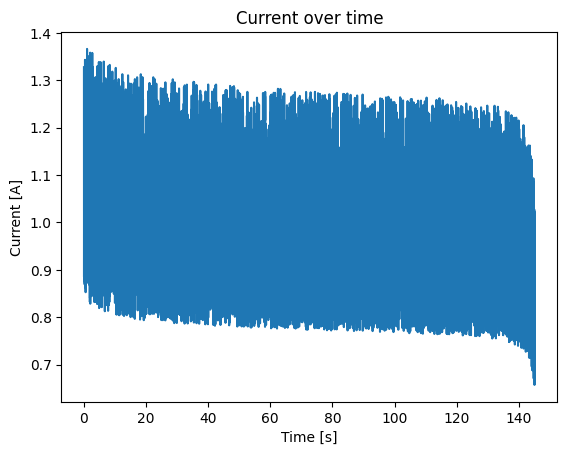

In [ ]:
n = 7260 #End of first cycle
Te = 0.02
i_measured = X[:n,0]
time = np.arange(0,n,1)*Te 
plt.plot(time, i_measured)
plt.title('Current over time')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.show()

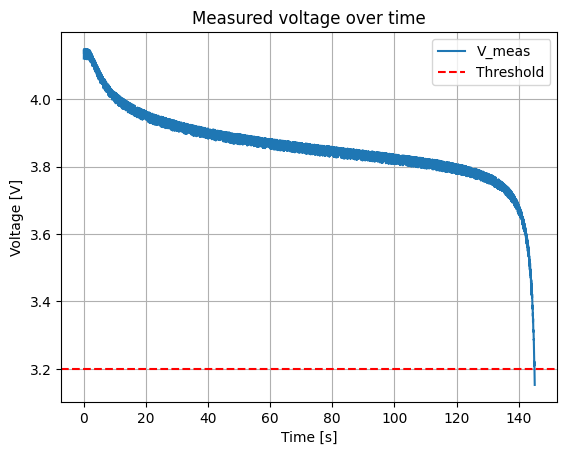

In [ ]:
n = 7260 #End of first cycle
Te = 0.02
v_measured = X[:n,1]
time = np.arange(0,n,1)*Te 
plt.plot(time, v_measured,label= 'V_meas')
plt.title('Measured voltage over time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.axhline(y=3.2, color='r', linestyle='--', label = 'Threshold')
plt.legend()
plt.grid()
plt.show()

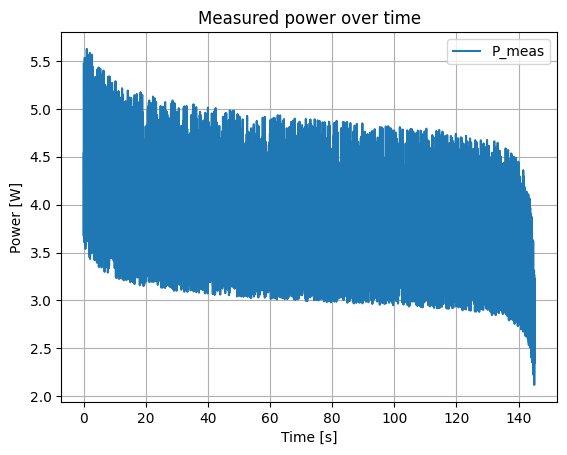

In [ ]:
n = 7260 #End of first cycle
Te = 0.02
p_measured = X[:n,2]
time = np.arange(0,n,1)*Te 
plt.plot(time, p_measured,label= 'P_meas')
plt.title('Measured power over time')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid()
plt.show()

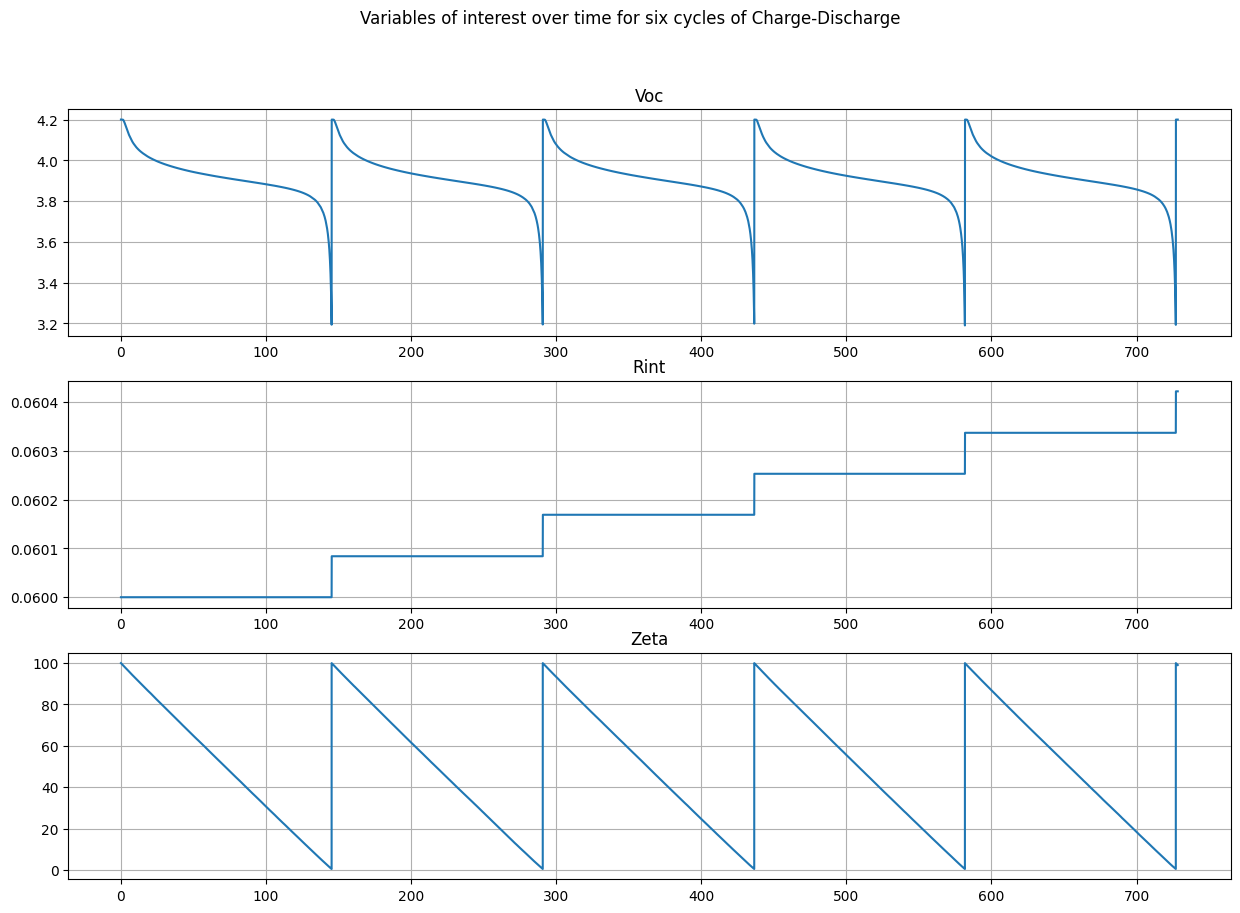

In [ ]:
n = 7284 #End of first cycle


Te = 0.02
voc = y[:n*5,0]
rint = y[:n*5,1]
zeta = y[:n*5,2]
time = np.arange(0,n*5,1)*Te 


fig, axs = plt.subplots(3,1, figsize = (15,10))
fig.suptitle('Variables of interest over time for six cycles of Charge-Discharge')
axs[0].plot(time, voc)
axs[0].set_title('Voc')
axs[0].grid()

axs[1].plot(time, rint)
axs[1].set_title('Rint')
axs[1].grid()

axs[2].plot(time, zeta)
axs[2].set_title('Zeta')
axs[2].grid()

plt.show()

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)

dummy_regr.predict(X)

score = dummy_regr.score(X, y)
print(f'Score for dummy regressor: {score}')

'''
score(X, y[, sample_weight])
Return the coefficient of determination R^2 of the prediction.
'''


Score for dummy regressor: 0.0


'\nscore(X, y[, sample_weight])\nReturn the coefficient of determination R^2 of the prediction.\n'

Iteration 1, loss = 0.03666281
Iteration 2, loss = 0.00301716
Iteration 3, loss = 0.00045277
Iteration 4, loss = 0.00021659
Iteration 5, loss = 0.00019206
Iteration 6, loss = 0.00021130
Iteration 7, loss = 0.00016932
Iteration 8, loss = 0.00020088
Iteration 9, loss = 0.00019182
Iteration 10, loss = 0.00022373
Iteration 11, loss = 0.00020955
Iteration 12, loss = 0.00019707
Iteration 13, loss = 0.00018984
Iteration 14, loss = 0.00023257
Iteration 15, loss = 0.00017348
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Score: 0.882


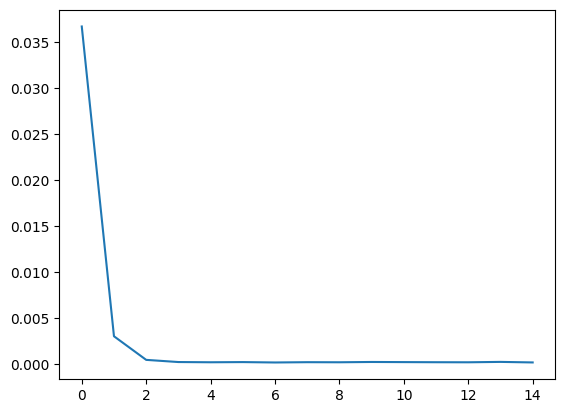

In [ ]:
#Using MLPRegressor Voc
y = Voc

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle = False, test_size=0.25)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


regr = MLPRegressor(hidden_layer_sizes=(128),
                    activation='relu',
                    alpha=0.0001,
                    random_state=1,
                    max_iter=500,
                    learning_rate_init=0.01,
                    verbose=True,
                    shuffle = False).fit(X_train_scaled, y_train)

y_pred = regr.predict(X_test_scaled)
print(f'Score: {r2_score(y_test, y_pred):.3f}')
loss = regr.loss_curve_
plt.plot(loss)

Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). In the general case when the true y is non-constant, a constant model that always predicts the average y disregarding the input features would get a score of 0.0. In the particular case when y_true is constant, the score is not finite: it is either NaN (perfect predictions) or -Inf (imperfect predictions). To prevent such non-finite numbers to pollute higher-level experiments such as a grid search cross-validation, by default these cases are replaced with 1.0 (perfect predictions) or 0.0 (imperfect predictions) respectively. You can set force_finite to False to prevent this fix from happening.

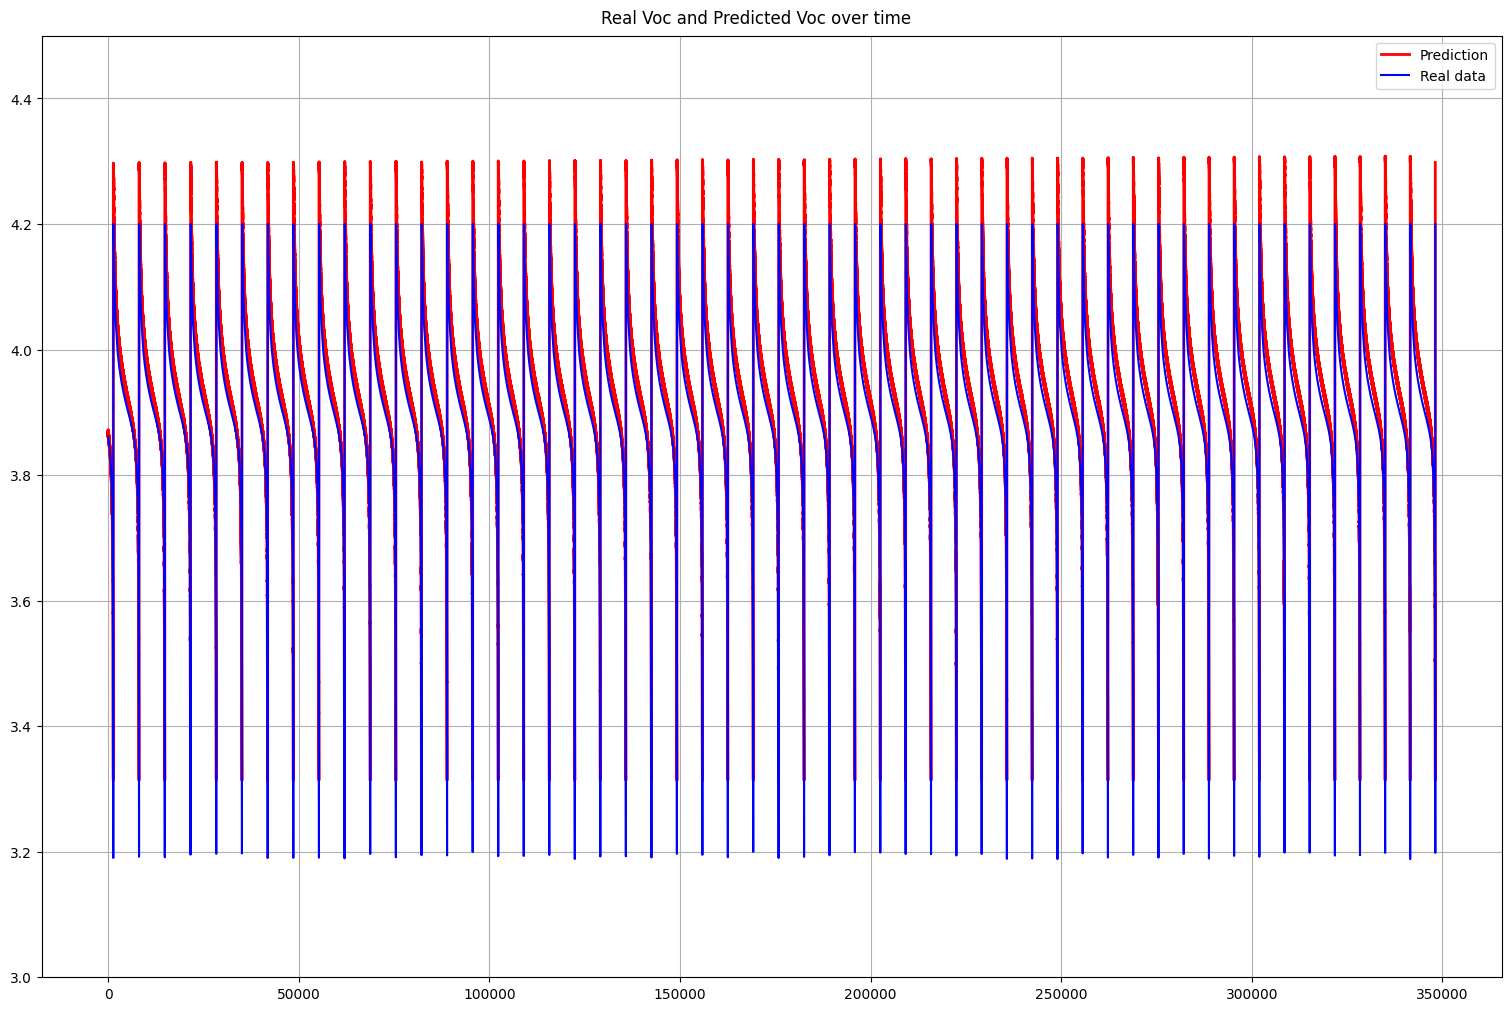

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
fig.suptitle('Real Voc and Predicted Voc over time')
ax.plot(y_pred, 'r-', linewidth=2, label='Prediction')
ax.plot(y_test, '-b', label='Real data')
ax.grid()
plt.ylim([3,4.5])
ax.legend()

Iteration 1, loss = 47.18292638
Iteration 2, loss = 18.86227449
Iteration 3, loss = 14.25659934
Iteration 4, loss = 11.03359758
Iteration 5, loss = 8.89249514
Iteration 6, loss = 7.70216665
Iteration 7, loss = 6.27126157
Iteration 8, loss = 5.72478368
Iteration 9, loss = 5.06256332
Iteration 10, loss = 4.33830172
Iteration 11, loss = 3.44494844
Iteration 12, loss = 2.75950493
Iteration 13, loss = 2.34291806
Iteration 14, loss = 1.96408513
Iteration 15, loss = 1.72975702
Iteration 16, loss = 1.51054198
Iteration 17, loss = 1.46659337
Iteration 18, loss = 1.44453194
Iteration 19, loss = 1.41442528
Iteration 20, loss = 1.38248964
Iteration 21, loss = 1.34731528
Iteration 22, loss = 1.31257307
Iteration 23, loss = 1.27534484
Iteration 24, loss = 1.23918926
Iteration 25, loss = 1.20159419
Iteration 26, loss = 1.14450460
Iteration 27, loss = 1.06719340
Iteration 28, loss = 1.02930926
Iteration 29, loss = 1.02080364
Iteration 30, loss = 1.03579284
Iteration 31, loss = 1.05402817
Iteration 32,

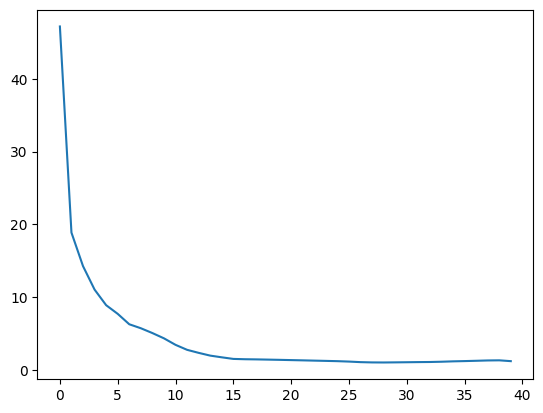

In [ ]:
#Using MLPRegressor Zeta
y = Zeta

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle = False, test_size=0.25)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


regr = MLPRegressor(hidden_layer_sizes=(128),
                    activation='relu',
                    alpha=0.0001,
                    random_state=1,
                    max_iter=500,
                    learning_rate_init=0.01,
                    verbose=True,
                    shuffle = False).fit(X_train_scaled, y_train)

y_pred = regr.predict(X_test_scaled)
print(f'Score: {r2_score(y_test, y_pred):.3f}')
loss = regr.loss_curve_
plt.plot(loss)

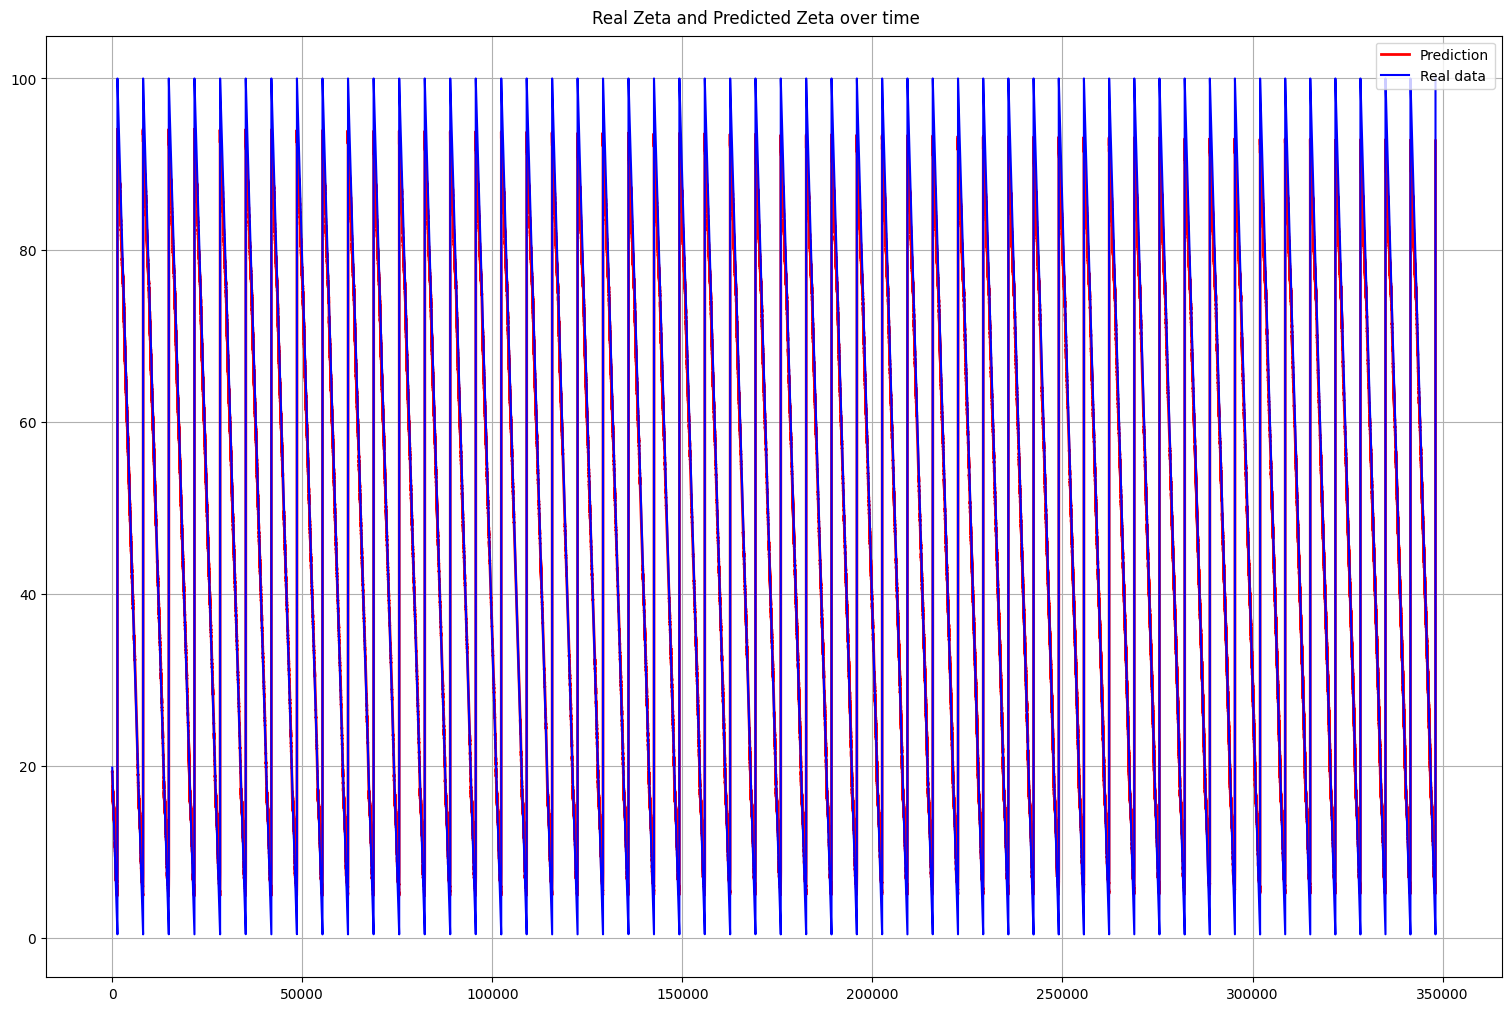

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
fig.suptitle('Real Zeta and Predicted Zeta over time')
ax.plot(y_pred, 'r-', linewidth=2, label='Prediction')
ax.plot(y_test, '-b', label='Real data')
ax.grid()
#plt.ylim([3,4.5])
ax.legend()

Iteration 1, loss = 0.00611751
Iteration 2, loss = 0.00000985
Iteration 3, loss = 0.00000869
Iteration 4, loss = 0.00000662
Iteration 5, loss = 0.00000234
Iteration 6, loss = 0.00000099
Iteration 7, loss = 0.00000068
Iteration 8, loss = 0.00000046
Iteration 9, loss = 0.00000030
Iteration 10, loss = 0.00000018
Iteration 11, loss = 0.00000007
Iteration 12, loss = 0.00000002
Iteration 13, loss = 0.00000002
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Score: 0.980


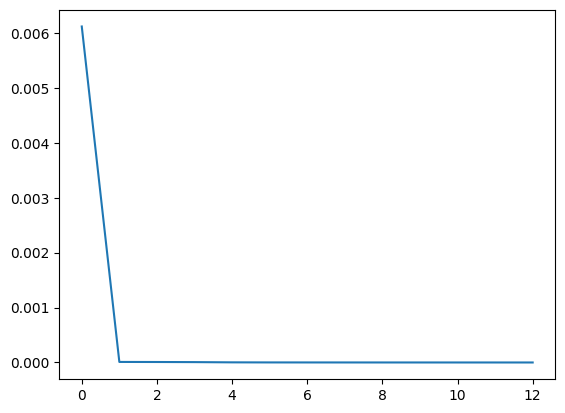

In [ ]:
#Using MLPRegressor Rint

y = Rint

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle = False, test_size=0.3)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


regr = MLPRegressor(hidden_layer_sizes=(16,4),
                    activation='relu',
                    alpha=0.0001,
                    random_state=1,
                    max_iter=500,
                    learning_rate_init=0.001,
                    verbose=True,
                    shuffle = True).fit(X_train_scaled, y_train) #Shuffle Whether to shuffle samples in each iteration. Only used when solver=’sgd’ or ‘adam’.

y_pred = regr.predict(X_test_scaled)
print(f'Score: {r2_score(y_test, y_pred):.3f}')
loss = regr.loss_curve_
plt.plot(loss)

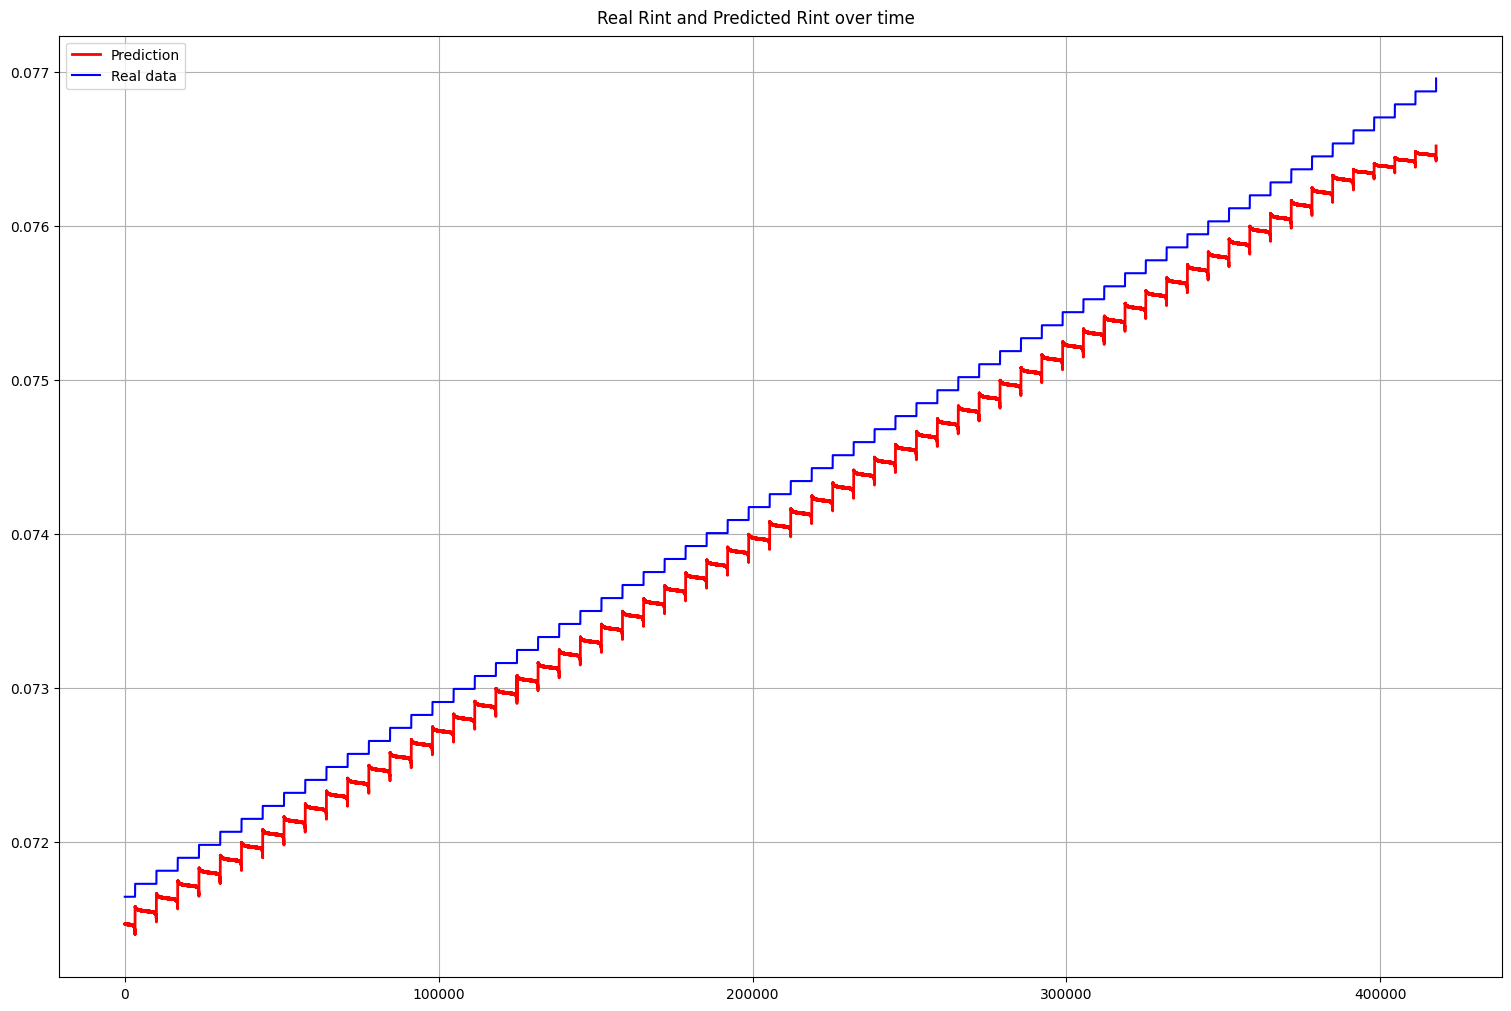

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
fig.suptitle('Real Rint and Predicted Rint over time')
ax.plot(y_pred, 'r-', linewidth=2, label='Prediction')
ax.plot(y_test, '-b', label='Real data')
ax.grid()
#plt.ylim([3,4.5])
ax.legend()